## 0. Setup

### 0.1 Install Packages

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 29 kB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=4d935477f24a5f462dfb3f547bd01e01002ccba66b5d1791c098e170ada35ed2
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-12-11 18:03:09--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-11 18:03:10--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-11 18:03:11--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [3]:
pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


### 0.2 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 0.3 Connect to GCP Big Query

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table
# GCP proejct
project_id = 'nlp-332020'
project_number = '1054321893028'

%env GCLOUD_PROJECT=project_id
# authenticate colab notebook
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project=project_id)

### 0.4 Import Libraries

In [ ]:
import sparknlp

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline 

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col, udf, regexp_replace, regexp_extract, lower, col, trim, split, explode, length
from pyspark.sql.types import IntegerType,  StructType, StructField, StringType
from pyspark.sql import functions as F

from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator,  TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

### 0.5 Initiate Spark Session

In [ ]:
spark = sparknlp.start()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

In [9]:
# print colab resources
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Not connected to a GPU
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## 1.0 Script Config

In [10]:
# change working directory 
%cd /content/drive/MyDrive/CSE6250/project/src/

# create data directory if not exist
DATA_DIR = 'data/'

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

# Readmittance threshold based on number of days
nDays = 30

#########################
#### MODEL SELECTION ####
#########################

# select the model to explore
# rf == Random Forest Classifier
# lg == Logistic Regression
# gb == Gradient Boosting Tree

model = 'rf'

# Use Spark NLP pipeline for text prepropocess and fitting models
spark_pipeline = True

if model == 'lr': 
    model = LogisticRegression(maxIter=100)

if model == 'rf':
    model = RandomForestClassifier(featuresCol = 'features', 
                                    labelCol = 'label', 
                                    numTrees=100, maxDepth=30)

if model == 'gb':
    model = GBTClassifier(featuresCol = 'features', 
                          labelCol="label",
                          maxIter=10, maxDepth=30)
    
print('Readmission Threshold:', nDays)
print('Model:', model)

/content/drive/MyDrive/CSE6250/project/src
Readmission Threshold: 30
Model: RandomForestClassifier_8c5636299d40


## 2.0 Data Preprocessing

In [ ]:
from etl import *
from utils import *


# extract data from big query
psc = readmission_etl(spark, client, nDays=30, s=11000)

# segment text from spark df
print('Segmenting texts...', datetime.now())
df = segment_text(spark, sqlContext, psc)

# free up memory
del psc

### 2.0 Split data into training and test dataset
# get train/val/test data sets
df_train, df_val, df_test = class_balance(df, nDays)

# save datasets
df_train.to_csv(DATA_DIR + 'train.csv', index=False)
df_val.to_csv(DATA_DIR + 'val.csv', index=False)
df_test.to_csv(DATA_DIR + 'test.csv', index=False)

Extracting readmission data using BigQuery... 2021-12-11 17:56:46.976881
Completed data extraction... performing etl... 2021-12-11 17:57:55.815178
Converting pandas to spark DF... 2021-12-11 17:57:55.859415
will build chunks: 4
(11000, 4)
(11000, 4)
(10100, 4)
Cleaning text from Note Events... 2021-12-11 17:58:03.014351
Completed script... 2021-12-11 17:58:03.802302


## 3.0 Modeling

converting pandas df to spark df... 2021-12-11 16:28:07.611914
Data set schema
root
 |-- ID: long (nullable = true)
 |-- Label: long (nullable = true)
 |-- TEXT: string (nullable = true)

None
setting up spark NLP pipeline... 2021-12-11 16:28:08.529282
Fitting model... 2021-12-11 16:28:08.566770
Fitted pipeline Schema
root
 |-- ID: long (nullable = true)
 |-- label: double (nullable = false)
 |-- TEXT: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cv: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

None
Completed script... 2021-12-11 16:28:52.576553


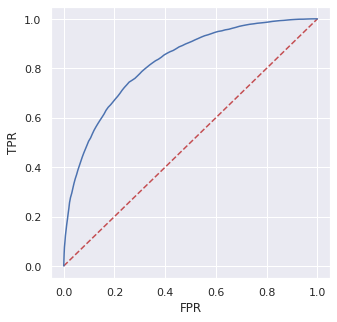

AUROC: 0.574
AUCPR: 0.598
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  283|
|  0.0|       1.0|  191|
|  1.0|       0.0|  429|
|  0.0|       0.0|  461|
+-----+----------+-----+

precision: 0.597
recall: 0.397
accuracy: 0.545
F1 score: 0.477
Validation Performance: None
AUROC: 0.584
AUCPR: 0.605
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  303|
|  0.0|       1.0|  190|
|  1.0|       0.0|  500|
|  0.0|       0.0|  511|
+-----+----------+-----+

precision: 0.615
recall: 0.377
accuracy: 0.541
F1 score: 0.468
Test Performance: None


In [ ]:
from models import *

if spark_pipeline:

  # train and fit spark nlp pipeline
  pipelineFit, val_pred, test_pred = spark_nlp_model(spark, df_train, 
                                                     df_val, df_test, model)

  # ROC Curve
  plot_roc(pipelineFit)

  # model performance
  print('Validation Performance:', get_metric(val_pred))
  print('Test Performance:', get_metric(test_pred))